## Assignment 4

### Import the required packages

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, RFECV, VarianceThreshold

import matplotlib.pyplot as plt

### Import the training data

In [2]:
# Import the training data 

parse_dates = ['ticket_issued_date', 'hearing_date', 'payment_date']
dtypes = {'ticket_id': int,
          'agency_name': str,
          'inspector_name': str,
          'violator_name': str,
          'violation_street_number': int,
          'violation_street_name': str,
          'violation_zip_code': float,
          'mailing_address_str_number': float,
          'mailing_address_str_name': str,
          'city': str,
          'state': str,
          'zip_code': str,
          'non_us_str_code': str,
          'country': str,
          'ticket_issued_date': str,
          'hearing_date': str,
          'violation_code': str,
          'violation_description': str,
          'disposition': str,
          'fine_amount': float,
          'admin_fee': float,
          'state_fee': float,
          'late_fee': float,
          'discount_amount': float,
          'clean_up_cost': float,
          'judgment_amount': float,
          'payment_amount': float,
          'payment_date': str,
          'payment_status': str,
          'collection_status': str,
          'grafitti_status': str,
          'compliance_detail': str,
          'compliance': float}

train_data = pd.read_csv('./train.csv',
             sep = ',',
             header = 0,
             encoding='latin-1',
             dtype=dtypes,
             parse_dates=parse_dates)

train_data.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaT,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaT,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaT,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaT,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


### Create dummy variables and keep only the columns for modelling

In [3]:
# suppress warning about overwriting dataframe
pd.options.mode.chained_assignment = None

# keep only the columns that do not have a missing value in compliance
train_data = train_data.dropna(subset = ['compliance'])

##### agency_name #####

# replace white space with underscore, remove any special characters and make lower case
def fix_text(col_name):
    train_data[col_name] = train_data[col_name].str.replace('\s+',"_")
    train_data[col_name] = train_data[col_name].str.replace('\W+',"")
    train_data[col_name] = train_data[col_name].str.lower()
    return;

fix_text('agency_name')

# get value counts for the agency_name
agency_name_counts = train_data['agency_name'].value_counts()

# remove the record that is Neighborhood City Halls as there is only one row and it is likely an outlier record
train_data = train_data[train_data.agency_name.str.contains("neighborhood_city_halls") == False]

# convert to dummy variables and merge back to the dataframe
agency_dummy = pd.get_dummies(train_data['agency_name'],prefix = 'agency')
agency_columns = list(agency_dummy)
train_data = train_data.merge(agency_dummy,left_index = True,right_index = True, how = 'left')
train_data[agency_columns] = train_data[agency_columns].fillna(0)

#####

##### violator_name #####

# replace white space with underscore, remove any special characters and make lower case
fix_text('violator_name')
    
# get value counts for violator_name
violator_name_counts = train_data['violator_name'].value_counts()

# now get dummy variables for all rows where the count is greater than 100
violator_name_gt_100 = train_data[train_data['violator_name'].
                                  isin(violator_name_counts[violator_name_counts > 100].index)]
violator_name_dummy = pd.get_dummies(violator_name_gt_100['violator_name'],prefix = 'violator')
violator_columns = list(violator_name_dummy)
train_data = train_data.merge(violator_name_dummy,left_index = True,right_index = True, how = 'left')
train_data[violator_columns] = train_data[violator_columns].fillna(0)

# flag violators that were banks
train_data['violator_bank'] = np.where(train_data['violator_name'].str.contains("BANK",regex = True), 1, 0)

#####

##### violation_street_name #####

# replace white space with underscore, remove any special characters and make lower case
fix_text('violation_street_name')

# get value counts for violation_street_name
violation_street_counts = train_data['violation_street_name'].value_counts()

# now get dummy variables for all rows where the count is greater than 100
violation_st_name_gt_100 = train_data[train_data['violation_street_name'].
                                  isin(violation_street_counts[violation_street_counts > 100].index)]
violation_st_name_dummy = pd.get_dummies(violation_st_name_gt_100['violation_street_name'],prefix = 'violation_st')
violation_st_name_columns = list(violation_st_name_dummy)
train_data = train_data.merge(violation_st_name_dummy,left_index = True,right_index = True, how = 'left')
train_data[violation_st_name_columns] = train_data[violation_st_name_columns].fillna(0)

#####

##### violation_zip_code #####

# count the number of missing values in the violation zip code
train_data['violation_zip_code'].notnull().sum()

#####

##### mailing_address_str_name #####

# get value counts for the mailing address street name
train_data['mailing_address_str_name']= train_data['mailing_address_str_name'].replace(['P.O. BOX', 'P.O. Box','P. O. BOX'], 'PO BOX')

# replace white space with underscore, remove any special characters and make lower case
fix_text('mailing_address_str_name')

mailing_address_counts = train_data['mailing_address_str_name'].value_counts()

# now get dummy variables for all rows where the count is greater than 100
mailing_address_gt_100 = train_data[train_data['mailing_address_str_name'].
                                   isin(mailing_address_counts[mailing_address_counts > 100].index)]
mailing_address_dummy = pd.get_dummies(mailing_address_gt_100['mailing_address_str_name'],prefix = 'mailing_st')
mailing_address_columns = list(mailing_address_dummy)
train_data = train_data.merge(mailing_address_dummy,left_index = True,right_index = True, how = 'left')
train_data[mailing_address_columns] = train_data[mailing_address_columns].fillna(0)

##### mailing_city #####

# get value counts for mailing city
train_data['city']= train_data['city'].replace(['Detroit', 'detroit'], 'DETROIT') 

# replace white space with underscore, remove any special characters and make lower case
fix_text('city')

city_counts = train_data['city'].value_counts()

# now get dummy variables for all rows where the count is greater than 100
city_gt_100 = train_data[train_data['city'].
                                   isin(city_counts[city_counts > 100].index)]
city_dummy = pd.get_dummies(city_gt_100['city'],prefix = 'city')
city_columns = list(city_dummy)
train_data = train_data.merge(city_dummy,left_index = True,right_index = True, how = 'left')
train_data[city_columns] = train_data[city_columns].fillna(0)

#####

##### state #####

# replace white space with underscore, remove any special characters and make lower case
fix_text('state')

# get value counts for mailing state
state_counts = train_data['state'].value_counts()

# now get dummy variables for all rows where the count is greater than 100
state_gt_100 = train_data[train_data['state'].
                                   isin(state_counts[state_counts > 100].index)]
state_dummy = pd.get_dummies(state_gt_100['state'],prefix = 'state')
state_columns = list(state_dummy)
train_data = train_data.merge(state_dummy,left_index = True,right_index = True, how = 'left')
train_data[state_columns] = train_data[state_columns].fillna(0)

#####

##### year_ticket_issued #####

# get value counts for the year of ticket_issued_date
train_data['year_ticket_issued'] = train_data['ticket_issued_date'].dt.year
ticket_date_counts = train_data['year_ticket_issued'].value_counts()

# create dummy variables for year issued
year_issued_dummy = pd.get_dummies(train_data['year_ticket_issued'],prefix = 'year_issued')
year_columns = list(year_issued_dummy)
train_data = train_data.merge(year_issued_dummy,left_index = True,right_index = True, how = 'left')
train_data[year_columns] = train_data[year_columns].fillna(0)

#####

##### year_hearing #####

# get value counts for the year of hearing_date
train_data['year_hearing'] = train_data['hearing_date'].dt.year
hearing_date_counts = train_data['year_hearing'].value_counts()

# create dummy variables for hearing_date
year_hearing_dummy = pd.get_dummies(train_data['year_hearing'],prefix = 'year_hearing')
year_columns = list(year_hearing_dummy)
train_data = train_data.merge(year_hearing_dummy,left_index = True,right_index = True, how = 'left')
train_data[year_columns] = train_data[year_columns].fillna(0)

#####

##### violation_code #####

# replace white space with underscore, remove any special characters and make lower case
fix_text('violation_code')

violation_counts = train_data['violation_code'].value_counts()

# now get dummy variables for all rows where the count is greater than 100
violation_code_gt_100 = train_data[train_data['violation_code'].
                                   isin(violation_counts[violation_counts > 100].index)]
violation_dummy = pd.get_dummies(violation_code_gt_100['violation_code'],prefix = 'violation_code')
violation_columns = list(violation_dummy)
train_data = train_data.merge(violation_dummy,left_index = True,right_index = True, how = 'left')
train_data[violation_columns] = train_data[violation_columns].fillna(0)

##### disposition #####

# create dummy variables for disposition
train_data['responsible_default'] = 0
train_data['responsible_default'][train_data['disposition'] == 'Responsible by Default'] = 1
    
train_data['responsible_admission'] = 0
train_data['responsible_admission'][train_data['disposition'] == 'Responsible by Admission'] = 1
    
train_data['responsible_determination'] = 0
train_data['responsible_determination'][train_data['disposition'] == 'Responsible by Determination'] = 1
    
train_data['pending_judgement'] = 0
train_data['pending_judgement'][train_data['disposition'] == 'PENDING JUDGMENT'] = 1
train_data['pending_judgement'][train_data['disposition'] == 'SET-ASIDE (PENDING JUDGMENT) '] = 1
    
train_data['responsible_waived'] = 0
train_data['responsible_waived'][train_data['disposition'] == 'Responsible (Fine Waived) by Deter'] = 1


#####

# drop columns not needed for modelling

drops = ['ticket_id', 'agency_name', 'inspector_name', 'violator_name', 'violation_street_number',\
         'violation_street_name', 'violation_zip_code', 'mailing_address_str_number', 'mailing_address_str_name',\
         'city', 'state', 'zip_code', 'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date', \
         'violation_code', 'violation_description', 'disposition', 'payment_amount', 'payment_date', \
          'payment_status', 'balance_due', 'collection_status', 'compliance_detail', 'clean_up_cost','grafitti_status', \
          'admin_fee','state_fee']
    
train_data.drop(drops, axis=1, inplace=True)

# replace the missing values in year_hearing
train_data['year_hearing'] = train_data['year_hearing'].fillna(9999)

train_data.head()


,fine_amount,late_fee,discount_amount,judgment_amount,compliance,agency_buildings_safety_engineering__env_department,agency_department_of_public_works,agency_detroit_police_department,agency_health_department,violator_apartments_carlton,...,violation_code_9143a__dwellin,violation_code_9143a__stories,violation_code_9143a__structu,violation_code_9181a,violation_code_9182d__dwellin,responsible_default,responsible_admission,responsible_determination,pending_judgement,responsible_waived
0,250.0,25.0,0.0,305.0,0.0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
1,750.0,75.0,0.0,855.0,1.0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
5,250.0,25.0,0.0,305.0,0.0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
6,750.0,75.0,0.0,855.0,0.0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
7,100.0,10.0,0.0,140.0,0.0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


### Split the data into training and valiation and standardize

In [4]:
# split the data randomly into training and validation datasets
X = train_data.drop('compliance', 1)
y = train_data['compliance']
    
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.7, random_state=0)

# standardize the data
stdsc = StandardScaler()
X_train_std = pd.DataFrame(stdsc.fit_transform(X_train))
X_train_std.columns = X_train.columns

X_valid_std = pd.DataFrame(stdsc.transform(X_valid))
X_valid_std.columns = X_valid.columns

X_train_std.head()

,fine_amount,late_fee,discount_amount,judgment_amount,agency_buildings_safety_engineering__env_department,agency_department_of_public_works,agency_detroit_police_department,agency_health_department,violator_apartments_carlton,violator_bank_na_wells_fargo,...,violation_code_9143a__dwellin,violation_code_9143a__stories,violation_code_9143a__structu,violation_code_9181a,violation_code_9182d__dwellin,responsible_default,responsible_admission,responsible_determination,pending_judgement,responsible_waived
0,0.214862,0.244895,-0.048022,0.217879,-1.227096,1.437182,-0.169233,-0.217136,-0.026239,-0.028994,...,-0.138554,-0.02837,-0.050171,-0.412753,-0.054299,0.394701,-0.306575,-0.22349,0.0,-0.036142
1,-0.231506,-0.200503,-0.048022,-0.228870,-1.227096,1.437182,-0.169233,-0.217136,-0.026239,-0.028994,...,-0.138554,-0.02837,-0.050171,-0.412753,-0.054299,0.394701,-0.306575,-0.22349,0.0,-0.036142
2,-0.157112,-0.126270,-0.048022,-0.154412,0.814932,-0.695806,-0.169233,-0.217136,-0.026239,-0.028994,...,-0.138554,-0.02837,-0.050171,2.422755,-0.054299,0.394701,-0.306575,-0.22349,0.0,-0.036142
3,-0.231506,-0.200503,-0.048022,-0.228870,-1.227096,-0.695806,-0.169233,4.605406,-0.026239,-0.028994,...,-0.138554,-0.02837,-0.050171,-0.412753,-0.054299,0.394701,-0.306575,-0.22349,0.0,-0.036142
4,-0.454690,-0.423202,-0.048022,-0.452244,-1.227096,1.437182,-0.169233,-0.217136,-0.026239,-0.028994,...,-0.138554,-0.02837,-0.050171,-0.412753,-0.054299,0.394701,-0.306575,-0.22349,0.0,-0.036142


### Run some variable selection methods and keep only the most predictive variables

In [5]:
### Remove features with zero variance ###
selector = VarianceThreshold()
selector.fit_transform(X_train_std)

# keep only the variables with variance > 0
X_train_std = X_train_std[X_train_std.columns[selector.get_support()]]
X_valid_std = X_valid_std[X_valid_std.columns[selector.get_support()]]


In [6]:
### Feature importance with Random Forest ###

feat_labels = pd.DataFrame(X_train_std.columns[1:])
forest = RandomForestClassifier(n_estimators = 500,
                               random_state = 0,
                               n_jobs = -1)
forest.fit(X_train, y_train)
importances = pd.DataFrame(forest.feature_importances_)

rf_importances = feat_labels.merge(importances,left_index = True, right_index = True)
rf_importances.columns = ['features','rf_importance']
rf_importances.sort_values('rf_importance', ascending = False, inplace = True) 
rf_importances['rf_rank'] = range(1, len(rf_importances) + 1)

# Check for overfitting by comparing the AUC of training and validation sets
y_score_train = forest.predict(X_train)
y_score_valid = forest.predict(X_valid)

print('Training AUC:', roc_auc_score(y_train, y_score_train))
print('Test AUC:', roc_auc_score(y_valid, y_score_valid))

Training AUC: 0.887721325354
Test AUC: 0.649405425012


In [7]:
### Feature selection with L1 regression ###

# fit the model
lr = linear_model.LogisticRegression(penalty = 'l1', C=0.007)
lr.fit(X_train_std, y_train)

# get the coefficients and features into a data frame and create the rank
lr_coeff = pd.DataFrame(lr.coef_).T
feat_labels = pd.DataFrame(X_train_std.columns[1:])
l1_reg_coeff = feat_labels.merge(lr_coeff,left_index = True, right_index = True)
l1_reg_coeff.columns = ['features','l1_coeff']
l1_reg_coeff['l1_coeff_abs'] = l1_reg_coeff['l1_coeff'].abs()
l1_reg_coeff.sort_values('l1_coeff_abs', ascending = False, inplace = True) 
l1_reg_coeff['l1_rank'] = range(1, len(l1_reg_coeff) + 1)

# set the rank of zero coefficents to missing
l1_reg_coeff['l1_rank'][l1_reg_coeff['l1_coeff'] == 0] = np.nan

# Check for overfitting by comparing the AUC of training and validation sets
y_score_lr_train = lr.decision_function(X_train_std)
fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, y_score_lr_train)
roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

y_score_lr_valid = lr.decision_function(X_valid_std)
fpr_lr_valid, tpr_lr_valid, _ = roc_curve(y_valid, y_score_lr_valid)
roc_auc_lr_valid = auc(fpr_lr_valid, tpr_lr_valid)

print('Training AUC:', roc_auc_lr_train)
print('Validation AUC:', roc_auc_lr_valid)

# merge the l1 regression coefficients to the rf importance ranks
var_importance = rf_importances.merge(l1_reg_coeff, on = 'features')

Training AUC: 0.812509842459
Validation AUC: 0.802828152726


In [8]:
# Keep only the features that were selected in L1
var_importance = var_importance[var_importance['l1_coeff_abs'] > 0]

# Calculate the mean rank and sort
var_importance['mean_rank'] = var_importance[["rf_rank", "l1_rank"]].mean(axis=1)
var_importance.sort_values("mean_rank", inplace = True)
var_importance

,features,rf_importance,rf_rank,l1_coeff,l1_coeff_abs,l1_rank,mean_rank
0,discount_amount,0.079951,1,-0.619322,0.619322,2.0,1.5
1,judgment_amount,0.047431,2,0.711179,0.711179,1.0,1.5
4,responsible_waived,0.033895,5,0.124118,0.124118,5.0,5.0
5,city_eastpointe,0.020984,6,-0.046538,0.046538,9.0,7.5
12,mailing_st_po_box_2103,0.006131,13,-0.084011,0.084011,6.0,9.5
13,violation_code_9143a__stories,0.006062,14,-0.076123,0.076123,7.0,10.5
15,agency_detroit_police_department,0.005005,16,0.036317,0.036317,13.0,14.5
9,city_southgate,0.007524,10,-0.021770,0.021770,32.0,21.0
25,violation_st_seward,0.003666,26,0.034537,0.034537,18.0,22.0
22,year_hearing_2010.0,0.004058,23,0.027975,0.027975,23.0,23.0


In [9]:
### Implement K best selection method ###
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

class SBS():
    def __init__(self, estimator, k_features, scoring = roc_auc_score, test_size = 0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.random_state = random_state
        self.test_size = test_size
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size = self.test_size,
                            random_state = self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r = dim-1):
                score = self._calc_score(X_train, y_train,
                                        X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train,
                   X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    

# Run the k best class

#knn = KNeighborsClassifier(n_neighbors = 2)
lr = linear_model.LogisticRegression(penalty = 'l1', C=0.007)
sbs = SBS(lr, k_features = 1)

# Keep the top 50 variables
top_vars = var_importance.iloc[:49,0].tolist()
X_train_top = X_train_std[top_vars]

X_train_top_mat = X_train_top.as_matrix()
y_train_mat = y_train.as_matrix()
sbs.fit(X_train_top_mat, y_train)

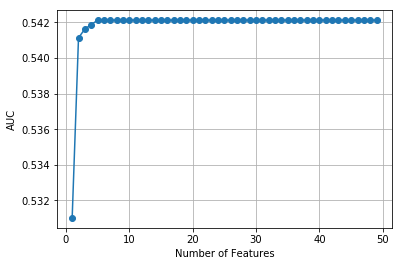

In [10]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylabel('AUC')
plt.xlabel('Number of Features')
plt.grid()
plt.show()

In [11]:
# Look at the solution with the top 5 variables
k5 = list(sbs.subsets_[44])
print(X_train_top.columns[1:][k5])

Index(['judgment_amount', 'city_eastpointe', 'city_southgate',
       'year_hearing_2009.0', 'mailing_st_fenmore'],
      dtype='object')


In [12]:
### Univariate variable selection

# Keep the top 50 variables
top_vars = var_importance.iloc[:49,0].tolist()
X_train_top = X_train_std[top_vars]

### F Test (t-test since there are only 2 groups)

fs = SelectKBest(score_func=f_classif, k=5)
fit = fs.fit(X_train_top, y_train)

selected_vars = X_train_top[X_train_top.columns[fs.get_support()]].columns
selected_vars

Index(['discount_amount', 'judgment_amount', 'responsible_waived',
       'agency_detroit_police_department', 'violation_code_22261'],
      dtype='object')

In [13]:
### Implement SelectFromModel

# get the top 50 variables
top_vars = var_importance.iloc[:49,0].tolist()
X_train_top = X_train_std[top_vars]

# Use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

sfm = SelectFromModel(clf, threshold = 1e-5)
sfm.fit(X_train_top, y_train)
n_features = sfm.transform(X_train_top).shape[1]

while n_features > 5:
    sfm.threshold += 0.0001
    X_transform = sfm.transform(X_train_top)
    n_features = X_transform.shape[1]
    
selected_vars = X_train_top[X_train_top.columns[sfm.get_support()]].columns
selected_vars

Index(['discount_amount', 'judgment_amount', 'responsible_waived',
       'year_hearing_2007.0', 'violation_code_22261'],
      dtype='object')

Optimal number of features : 4


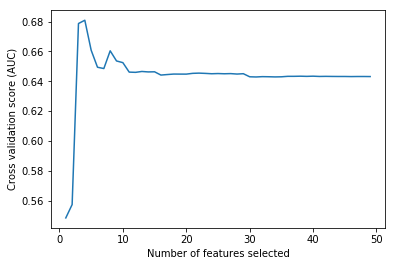

Index(['discount_amount', 'judgment_amount', 'responsible_waived',
       'violation_code_22261'],
      dtype='object')

In [14]:
### Implement RFE (Recursive Feature Elimination)

# get the top 50 variables
top_vars = var_importance.iloc[:49,0].tolist()
X_train_top = X_train_std[top_vars]

# Use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()

rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(2),
              scoring='roc_auc')

rfecv.fit(X_train_top, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (AUC)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

selected_vars = X_train_top[X_train_top.columns[rfecv.support_]].columns
selected_vars

### Keep only variables likely to be predictive based on feature selection

In [6]:
# Keep everything that was selected by the l1 model
# keeps = var_importance['features'].tolist()
# X_train_std = X_train_std[keeps]
# X_valid_std = X_valid_std[keeps]

# X_train_std.head()

X_train_std = X_train_std[['discount_amount', 'judgment_amount', 'responsible_waived',
                                'violation_code_22261','year_hearing_2007.0','agency_detroit_police_department',
                               'city_eastpointe', 'city_southgate','year_hearing_2009.0', 'mailing_st_fenmore',
                               'mailing_st_po_box_2103','violation_code_9143a__stories','violation_st_seward',
                               'year_hearing_2010.0','violation_code_22283','year_issued_2011',
                                'violator_apartments_carlton','agency_health_department','mailing_st_wyoming',
                                'violation_st_hartwell',
                               'violation_st_ellsworth','violation_st_grandmont','year_issued_2007',
                               'violation_st_military','mailing_st_beaverland','violation_st_joann',
                                'violation_st_log_cabin','violation_st_dean']]

X_valid_std = X_valid_std[['discount_amount', 'judgment_amount', 'responsible_waived',
                                'violation_code_22261','year_hearing_2007.0','agency_detroit_police_department',
                               'city_eastpointe', 'city_southgate','year_hearing_2009.0', 'mailing_st_fenmore',
                               'mailing_st_po_box_2103','violation_code_9143a__stories','violation_st_seward',
                               'year_hearing_2010.0','violation_code_22283','year_issued_2011',
                                'violator_apartments_carlton','agency_health_department','mailing_st_wyoming',
                                'violation_st_hartwell',
                               'violation_st_ellsworth','violation_st_grandmont','year_issued_2007',
                               'violation_st_military','mailing_st_beaverland','violation_st_joann',
                                'violation_st_log_cabin','violation_st_dean']]

X_train_std.head()

,discount_amount,judgment_amount,responsible_waived,violation_code_22261,year_hearing_2007.0,agency_detroit_police_department,city_eastpointe,city_southgate,year_hearing_2009.0,mailing_st_fenmore,...,mailing_st_wyoming,violation_st_hartwell,violation_st_ellsworth,violation_st_grandmont,year_issued_2007,violation_st_military,mailing_st_beaverland,violation_st_joann,violation_st_log_cabin,violation_st_dean
0,-0.048022,0.217879,-0.036142,-0.066518,-0.438517,-0.169233,-0.060712,-0.029453,-0.411507,-0.027407,...,-0.055121,-0.052017,-0.026239,-0.039119,2.182877,-0.035264,-0.027243,-0.031932,-0.035894,-0.03079
1,-0.048022,-0.228870,-0.036142,-0.066518,-0.438517,-0.169233,-0.060712,-0.029453,-0.411507,-0.027407,...,-0.055121,-0.052017,-0.026239,-0.039119,-0.458111,-0.035264,-0.027243,-0.031932,-0.035894,-0.03079
2,-0.048022,-0.154412,-0.036142,-0.066518,-0.438517,-0.169233,-0.060712,-0.029453,-0.411507,-0.027407,...,-0.055121,-0.052017,-0.026239,-0.039119,-0.458111,-0.035264,-0.027243,-0.031932,-0.035894,-0.03079
3,-0.048022,-0.228870,-0.036142,-0.066518,-0.438517,-0.169233,-0.060712,-0.029453,-0.411507,-0.027407,...,-0.055121,-0.052017,-0.026239,-0.039119,-0.458111,-0.035264,-0.027243,-0.031932,-0.035894,-0.03079
4,-0.048022,-0.452244,-0.036142,-0.066518,-0.438517,-0.169233,-0.060712,-0.029453,2.430092,-0.027407,...,-0.055121,-0.052017,-0.026239,-0.039119,-0.458111,-0.035264,-0.027243,-0.031932,-0.035894,-0.03079


### Fit a Random Forest Model and get validation AUC

In [14]:
### Random Forest ###

rfc = RandomForestClassifier(random_state = 0) 

param_grid = {'n_estimators': [25, 50, 100],
              'max_features': ['auto', 'sqrt', 'log2']}
    
CV_rfc = GridSearchCV(estimator=rfc, 
                      param_grid=param_grid, 
                      cv= 5, 
                      scoring='roc_auc',
                      n_jobs = -1)

CV_rfc.fit(X_train_std, y_train)

# Check for overfitting by comparing the AUC of training and validation sets
print('Accuracy of RF classifier on train set: {:.2f}'
     .format(CV_rfc.score(X_train_std, y_train)))
print('Accuracy of RF classifier on validation set: {:.2f}'
     .format(CV_rfc.score(X_valid_std, y_valid)))

# get the best parameters from the CV
CV_rfc.best_estimator_

Accuracy of RF classifier on train set: 0.78
Accuracy of RF classifier on validation set: 0.75


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [17]:
### L1 Regression ###

lr_l1 = linear_model.LogisticRegression(penalty = 'l1', random_state = 0)

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

CV_lr_l1 = GridSearchCV(estimator=lr_l1, 
                        param_grid=param_grid, 
                        cv= 5, 
                        scoring='roc_auc',
                        n_jobs = -1)

CV_lr_l1.fit(X_train_std, y_train)

print('Accuracy of l1 reg classifier on train set: {:.2f}'
     .format(CV_lr_l1.score(X_train_std, y_train)))
print('Accuracy of l1 reg classifier on validation set: {:.2f}'
     .format(CV_lr_l1.score(X_valid_std, y_valid)))


Accuracy of l1 reg classifier on train set: 0.68
Accuracy of l1 reg classifier on validation set: 0.68


In [19]:
### L2 Regression ###

lr_l2 = linear_model.LogisticRegression(penalty = 'l2', random_state = 0)

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 2000]}

CV_lr_l2 = GridSearchCV(estimator=lr_l2, 
                        param_grid=param_grid, 
                        cv= 5, 
                        scoring='roc_auc',
                        n_jobs = -1)

CV_lr_l2.fit(X_train_std, y_train)
print('Accuracy of l2 reg classifier on train set: {:.2f}'
     .format(CV_lr_l2.score(X_train_std, y_train)))
print('Accuracy of l2 reg classifier on validation set: {:.2f}'
     .format(CV_lr_l2.score(X_valid_std, y_valid)))

# get the best parameters from the CV
CV_lr_l2.best_estimator_

Accuracy of l2 reg classifier on train set: 0.67
Accuracy of l2 reg classifier on validation set: 0.67


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
### SVM ###

SVM = SVC(kernel='rbf', random_state = 0)
param_grid = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

CV_SVM = GridSearchCV(estimator=SVM, 
                      param_grid=param_grid, 
                      cv= 5, 
                      scoring='roc_auc',
                      n_jobs = -1)

CV_SVM.fit(X_train_std, y_train)

print('Accuracy of SVM classifier on train set: {:.2f}'
     .format(CV_SVM.score(X_train_std, y_train)))
print('Accuracy of SVM classifier on validation set: {:.2f}'
     .format(CV_SVM.score(X_valid_std, y_valid)))

# get the best parameters from the CV
CV_SVM.best_estimator_

Accuracy of SVM classifier on train set: 0.53
Accuracy of SVM classifier on validation set: 0.53


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
### Gradient Boosting ####

GBM = GradientBoostingClassifier(random_state = 0)

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3,4,5]}

CV_GBM = GridSearchCV(estimator=GBM, 
                      param_grid=param_grid, 
                      cv= 5, 
                      scoring='roc_auc',
                      n_jobs = -1)

CV_GBM.fit(X_train_std, y_train)

print('Accuracy of GBM classifier on train set: {:.2f}'
     .format(CV_GBM.score(X_train_std, y_train)))
print('Accuracy of GBM classifier on validation set: {:.2f}'
     .format(CV_GBM.score(X_valid_std, y_valid)))

# get the best parameters from the CV
CV_GBM.best_estimator_

Accuracy of GBM classifier on train set: 0.77
Accuracy of GBM classifier on validation set: 0.76


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

ROC AUC GBM: 0.76
ROC AUC RF: 0.75
ROC AUC l1 reg: 0.68
ROC AUC l2 reg: 0.67


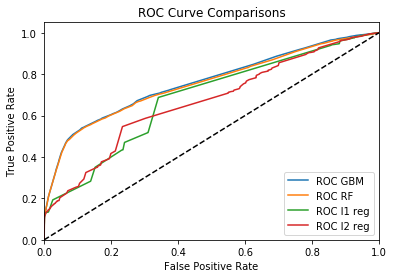

In [20]:
### Plot ROC curves

## Gradient Boosing
fpr_GBM, tpr_GBM, _ = roc_curve(y_valid, CV_GBM.predict_proba(X_valid_std)[:,1])
roc_auc_GBM = auc(fpr_GBM, tpr_GBM)
print('ROC AUC GBM: %0.2f' % roc_auc_GBM)

## Random Forest
fpr_rfc, tpr_rfc, _ = roc_curve(y_valid, CV_rfc.predict_proba(X_valid_std)[:,1])
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
print('ROC AUC RF: %0.2f' % roc_auc_rfc)

## L1 Regression
fpr_l1, tpr_l1, _ = roc_curve(y_valid, CV_lr_l1.predict_proba(X_valid_std)[:,1])
roc_auc_l1 = auc(fpr_l1, tpr_l1)
print('ROC AUC l1 reg: %0.2f' % roc_auc_l1)

## L2 Regression
fpr_l2, tpr_l2, _ = roc_curve(y_valid, CV_lr_l2.predict_proba(X_valid_std)[:,1])
roc_auc_l2 = auc(fpr_l2, tpr_l2)
print('ROC AUC l2 reg: %0.2f' % roc_auc_l2)

# Plot curves
plt.figure()
plt.plot(fpr_GBM, tpr_GBM, label='ROC GBM' % roc_auc_GBM)
plt.plot(fpr_rfc, tpr_rfc, label='ROC RF' % roc_auc_rfc)
plt.plot(fpr_l1, tpr_l1, label='ROC l1 reg' % roc_auc_l1)
plt.plot(fpr_l2, tpr_l2, label='ROC l2 reg' % roc_auc_l2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparisons')
plt.legend(loc="lower right")
plt.show()

In [22]:
### The GBM model seems to be the best, get the feature importances

feat_labels = pd.DataFrame(X_train_std.columns[1:])
importances = pd.DataFrame(CV_GBM.best_estimator_.feature_importances_)

GBM_importances = feat_labels.merge(importances,left_index = True, right_index = True)
GBM_importances.columns = ['features','GBM_importance']
GBM_importances.sort_values('GBM_importance', ascending = False, inplace = True) 
GBM_importances['GBM_rank'] = range(1, len(GBM_importances) + 1)
GBM_importances

,features,GBM_importance,GBM_rank
1,responsible_waived,0.648361,1
0,judgment_amount,0.111415,2
15,violator_apartments_carlton,0.025327,3
8,mailing_st_fenmore,0.023375,4
5,city_eastpointe,0.020171,5
22,violation_st_military,0.019844,6
4,agency_detroit_police_department,0.017699,7
17,mailing_st_wyoming,0.016743,8
6,city_southgate,0.014563,9
13,violation_code_22283,0.013176,10


In [57]:
### Try fitting the GBM model with different numbers of variables

for x in range(1, 28):
    top_vars = GBM_importances.loc[GBM_importances['GBM_rank'] <= x]
    keeps = top_vars['features'].tolist()
    X_train_std2 = X_train_std[keeps]
    X_valid_std2 = X_valid_std[keeps]

    GBM = GradientBoostingClassifier(random_state = 0,
                                    n_estimators = 100,
                                    max_depth = 5,
                                    learning_rate = 0.1)

    GBM.fit(X_train_std2, y_train)

    fpr, tpr, _ = roc_curve(y_valid, GBM.predict_proba(X_valid_std2)[:,1])
    roc_auc = auc(fpr, tpr)

    print('AUC of GBM classifier on validation set: {:.2f} with {} variables'
         .format(roc_auc, x))


AUC of GBM classifier on validation set: 0.51 with 1 variables
AUC of GBM classifier on validation set: 0.75 with 2 variables
AUC of GBM classifier on validation set: 0.75 with 3 variables
AUC of GBM classifier on validation set: 0.75 with 4 variables
AUC of GBM classifier on validation set: 0.75 with 5 variables
AUC of GBM classifier on validation set: 0.75 with 6 variables
AUC of GBM classifier on validation set: 0.75 with 7 variables
AUC of GBM classifier on validation set: 0.75 with 8 variables
AUC of GBM classifier on validation set: 0.75 with 9 variables
AUC of GBM classifier on validation set: 0.75 with 10 variables
AUC of GBM classifier on validation set: 0.75 with 11 variables
AUC of GBM classifier on validation set: 0.75 with 12 variables
AUC of GBM classifier on validation set: 0.75 with 13 variables
AUC of GBM classifier on validation set: 0.76 with 14 variables
AUC of GBM classifier on validation set: 0.76 with 15 variables
AUC of GBM classifier on validation set: 0.76 wit